In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 15:36 - loss: 0.2380 - STD: 1.5279e-04 - MAE: 0.4789

 10/793 [..............................] - ETA: 4s - loss: 0.0472 - STD: 2.3411e-04 - MAE: 0.1638   

 19/793 [..............................] - ETA: 4s - loss: 0.0376 - STD: 1.2814e-04 - MAE: 0.1498

 28/793 [>.............................] - ETA: 4s - loss: 0.0303 - STD: 9.4530e-05 - MAE: 0.1310

 37/793 [>.............................] - ETA: 4s - loss: 0.0255 - STD: 7.8843e-05 - MAE: 0.1200

 46/793 [>.............................] - ETA: 4s - loss: 0.0224 - STD: 6.6851e-05 - MAE: 0.1116

 54/793 [=>............................] - ETA: 4s - loss: 0.0204 - STD: 5.8895e-05 - MAE: 0.1059

 63/793 [=>............................] - ETA: 4s - loss: 0.0189 - STD: 5.2591e-05 - MAE: 0.1017

 72/793 [=>............................] - ETA: 4s - loss: 0.0177 - STD: 4.8019e-05 - MAE: 0.0986

 81/793 [==>...........................] - ETA: 4s - loss: 0.0168 - STD: 4.4541e-05 - MAE: 0.0959

 90/793 [==>...........................] - ETA: 4s - loss: 0.0160 - STD: 4.1969e-05 - MAE: 0.0937

 99/793 [==>...........................] - ETA: 4s - loss: 0.0153 - STD: 4.0094e-05 - MAE: 0.0919

107/793 [===>..........................] - ETA: 4s - loss: 0.0149 - STD: 3.8889e-05 - MAE: 0.0907

116/793 [===>..........................] - ETA: 4s - loss: 0.0144 - STD: 3.7992e-05 - MAE: 0.0895

125/793 [===>..........................] - ETA: 4s - loss: 0.0141 - STD: 3.7515e-05 - MAE: 0.0885

134/793 [====>.........................] - ETA: 3s - loss: 0.0137 - STD: 3.7451e-05 - MAE: 0.0877

142/793 [====>.........................] - ETA: 3s - loss: 0.0135 - STD: 3.7735e-05 - MAE: 0.0870

150/793 [====>.........................] - ETA: 3s - loss: 0.0133 - STD: 3.8323e-05 - MAE: 0.0863

159/793 [=====>........................] - ETA: 3s - loss: 0.0130 - STD: 3.9429e-05 - MAE: 0.0857

168/793 [=====>........................] - ETA: 3s - loss: 0.0128 - STD: 4.0969e-05 - MAE: 0.0851

177/793 [=====>........................] - ETA: 3s - loss: 0.0126 - STD: 4.3099e-05 - MAE: 0.0846

186/793 [======>.......................] - ETA: 3s - loss: 0.0125 - STD: 4.5891e-05 - MAE: 0.0842

194/793 [======>.......................] - ETA: 3s - loss: 0.0123 - STD: 4.9058e-05 - MAE: 0.0838

203/793 [======>.......................] - ETA: 3s - loss: 0.0122 - STD: 5.3583e-05 - MAE: 0.0835

212/793 [=======>......................] - ETA: 3s - loss: 0.0121 - STD: 5.9470e-05 - MAE: 0.0832

221/793 [=======>......................] - ETA: 3s - loss: 0.0120 - STD: 6.7073e-05 - MAE: 0.0829

230/793 [=======>......................] - ETA: 3s - loss: 0.0119 - STD: 7.6987e-05 - MAE: 0.0826

238/793 [========>.....................] - ETA: 3s - loss: 0.0118 - STD: 8.8442e-05 - MAE: 0.0824

247/793 [========>.....................] - ETA: 3s - loss: 0.0117 - STD: 1.0562e-04 - MAE: 0.0821

255/793 [========>.....................] - ETA: 3s - loss: 0.0116 - STD: 1.2658e-04 - MAE: 0.0819

263/793 [========>.....................] - ETA: 3s - loss: 0.0115 - STD: 1.5488e-04 - MAE: 0.0817

272/793 [=========>....................] - ETA: 3s - loss: 0.0115 - STD: 1.9901e-04 - MAE: 0.0815

280/793 [=========>....................] - ETA: 3s - loss: 0.0114 - STD: 2.5338e-04 - MAE: 0.0813

289/793 [=========>....................] - ETA: 3s - loss: 0.0113 - STD: 3.4161e-04 - MAE: 0.0811

298/793 [==========>...................] - ETA: 3s - loss: 0.0112 - STD: 4.6659e-04 - MAE: 0.0808

307/793 [==========>...................] - ETA: 2s - loss: 0.0112 - STD: 6.4186e-04 - MAE: 0.0806

316/793 [==========>...................] - ETA: 2s - loss: 0.0111 - STD: 8.9109e-04 - MAE: 0.0803

324/793 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 0.0012 - MAE: 0.0802    

332/793 [===========>..................] - ETA: 2s - loss: 0.0109 - STD: 0.0016 - MAE: 0.0799

341/793 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 0.0021 - MAE: 0.0797

350/793 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.0028 - MAE: 0.0794

359/793 [============>.................] - ETA: 2s - loss: 0.0107 - STD: 0.0036 - MAE: 0.0791

368/793 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 0.0044 - MAE: 0.0788

376/793 [=============>................] - ETA: 3s - loss: 0.0105 - STD: 0.0051 - MAE: 0.0786

387/793 [=============>................] - ETA: 3s - loss: 0.0104 - STD: 0.0061 - MAE: 0.0782

396/793 [=============>................] - ETA: 3s - loss: 0.0104 - STD: 0.0068 - MAE: 0.0779

404/793 [==============>...............] - ETA: 2s - loss: 0.0103 - STD: 0.0075 - MAE: 0.0777

413/793 [==============>...............] - ETA: 2s - loss: 0.0102 - STD: 0.0082 - MAE: 0.0774

421/793 [==============>...............] - ETA: 2s - loss: 0.0102 - STD: 0.0089 - MAE: 0.0771

429/793 [===============>..............] - ETA: 2s - loss: 0.0101 - STD: 0.0095 - MAE: 0.0768

437/793 [===============>..............] - ETA: 2s - loss: 0.0100 - STD: 0.0102 - MAE: 0.0765

446/793 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 0.0110 - MAE: 0.0762

455/793 [================>.............] - ETA: 2s - loss: 0.0098 - STD: 0.0118 - MAE: 0.0758

464/793 [================>.............] - ETA: 2s - loss: 0.0098 - STD: 0.0127 - MAE: 0.0754

472/793 [================>.............] - ETA: 2s - loss: 0.0097 - STD: 0.0134 - MAE: 0.0751

480/793 [=================>............] - ETA: 2s - loss: 0.0096 - STD: 0.0141 - MAE: 0.0747

489/793 [=================>............] - ETA: 2s - loss: 0.0095 - STD: 0.0149 - MAE: 0.0744

498/793 [=================>............] - ETA: 2s - loss: 0.0094 - STD: 0.0157 - MAE: 0.0741

507/793 [==================>...........] - ETA: 2s - loss: 0.0094 - STD: 0.0164 - MAE: 0.0737

516/793 [==================>...........] - ETA: 2s - loss: 0.0093 - STD: 0.0172 - MAE: 0.0734

524/793 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.0178 - MAE: 0.0731

533/793 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0185 - MAE: 0.0728

542/793 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0193 - MAE: 0.0724

551/793 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.0199 - MAE: 0.0721

560/793 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.0206 - MAE: 0.0718

568/793 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0212 - MAE: 0.0715

577/793 [====================>.........] - ETA: 1s - loss: 0.0088 - STD: 0.0219 - MAE: 0.0712

585/793 [=====================>........] - ETA: 1s - loss: 0.0088 - STD: 0.0225 - MAE: 0.0709

593/793 [=====================>........] - ETA: 1s - loss: 0.0087 - STD: 0.0230 - MAE: 0.0706

601/793 [=====================>........] - ETA: 1s - loss: 0.0087 - STD: 0.0236 - MAE: 0.0704

609/793 [======================>.......] - ETA: 1s - loss: 0.0086 - STD: 0.0241 - MAE: 0.0701

618/793 [======================>.......] - ETA: 1s - loss: 0.0085 - STD: 0.0248 - MAE: 0.0698

627/793 [======================>.......] - ETA: 1s - loss: 0.0085 - STD: 0.0253 - MAE: 0.0696

636/793 [=======================>......] - ETA: 1s - loss: 0.0084 - STD: 0.0259 - MAE: 0.0693

645/793 [=======================>......] - ETA: 1s - loss: 0.0084 - STD: 0.0265 - MAE: 0.0690

653/793 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0270 - MAE: 0.0688

661/793 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0274 - MAE: 0.0685

670/793 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0280 - MAE: 0.0683

679/793 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0285 - MAE: 0.0680

688/793 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0290 - MAE: 0.0678

697/793 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0295 - MAE: 0.0676

705/793 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0299 - MAE: 0.0674

714/793 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0304 - MAE: 0.0672

723/793 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0309 - MAE: 0.0669

732/793 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0313 - MAE: 0.0667

741/793 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0318 - MAE: 0.0665

749/793 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0322 - MAE: 0.0663

758/793 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0326 - MAE: 0.0661

767/793 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.0330 - MAE: 0.0659

776/793 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.0334 - MAE: 0.0657

785/793 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0338 - MAE: 0.0655

793/793 [==============================] - ETA: 0s - loss: 0.0076 - STD: 0.0342 - MAE: 0.0653

793/793 [==============================] - 7s 8ms/step - loss: 0.0076 - STD: 0.0342 - MAE: 0.0653 - val_loss: 0.0035 - val_STD: 0.0533 - val_MAE: 0.0438


Epoch 2/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

  9/793 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0478 

 18/793 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0681 - MAE: 0.0483

 27/793 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0483

 36/793 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0484

 45/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0481

 53/793 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0479

 62/793 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0477

 71/793 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0477

 80/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

 88/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0475

 96/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0474

105/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0473

114/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0472

123/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0471

132/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

140/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

149/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0472

158/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

167/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

176/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0471

185/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0470

194/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0470

203/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0469

212/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

221/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0470

230/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

238/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0469

247/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

256/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0468

265/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

274/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0466

282/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0466

291/793 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

300/793 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0465

309/793 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0464

318/793 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0464

326/793 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0464

335/793 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

344/793 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0463

353/793 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0463

362/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0462

370/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0462

379/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0461

388/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

396/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

405/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

414/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

423/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0462

432/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

441/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

449/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

456/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

462/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

470/793 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

479/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

488/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

497/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

505/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0459

510/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

515/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

520/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

528/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

537/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

546/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

555/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

564/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

573/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

582/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

590/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

597/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

605/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

613/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0456

622/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0456

631/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0456

640/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0456

649/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0456

658/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0456

667/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

676/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

685/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

694/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

703/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

711/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

719/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

725/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

734/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

743/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

752/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

760/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

767/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

772/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

777/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

783/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

791/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

793/793 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453 - val_loss: 0.0030 - val_STD: 0.0594 - val_MAE: 0.0404


Epoch 3/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0436

  8/793 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452 

 14/793 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0447

 23/793 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0441

 32/793 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0438

 41/793 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

 49/793 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0436

 56/793 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

 61/793 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

 66/793 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

 72/793 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

 80/793 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0435

 89/793 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

 98/793 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

107/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

116/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

125/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

134/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

142/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

148/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

156/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

165/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

174/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

182/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

191/793 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

199/793 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

208/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

217/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

226/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

235/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

243/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

252/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

260/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

268/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

277/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

286/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

295/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

303/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

311/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

317/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

326/793 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

335/793 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

344/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

352/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

360/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

365/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

370/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

375/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

383/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

392/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

401/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

410/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

418/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

427/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

436/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

444/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

451/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

457/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

466/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

475/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

484/793 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

492/793 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

499/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

504/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

509/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

514/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

522/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

531/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

540/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

549/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

558/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

566/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

574/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

582/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

589/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

597/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

606/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

615/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

624/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

633/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

642/793 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

651/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

660/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

669/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

678/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

687/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

696/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

705/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

714/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

722/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

728/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

737/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

746/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

755/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

763/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

770/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

775/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

780/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

786/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

793/793 [==============================] - 6s 7ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431 - val_loss: 0.0029 - val_STD: 0.0626 - val_MAE: 0.0401


Epoch 4/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0418

  8/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0423 

 16/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0422

 23/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0421

 31/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 39/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

 47/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

 55/793 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

 63/793 [=>............................] - ETA: 5s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

 71/793 [=>............................] - ETA: 5s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 79/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

 88/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 97/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

106/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

115/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

123/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

131/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

140/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

149/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

157/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

166/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

175/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

184/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

193/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

202/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

211/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

220/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

229/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

238/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

247/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0421

256/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

265/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

274/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

283/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

292/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

301/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

310/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

319/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

328/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

337/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

346/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

354/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

361/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

370/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

379/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

386/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

394/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

403/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

412/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

420/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

428/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

436/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

444/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

451/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

458/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

466/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

474/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

481/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

488/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

496/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

503/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

510/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

518/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

525/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

532/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

539/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

546/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

553/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

560/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

567/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

574/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

581/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

588/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

595/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

603/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

611/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

618/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

626/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

633/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

640/793 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

648/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

655/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

662/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

670/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

677/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

682/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

688/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

693/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

699/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

707/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

715/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

722/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

728/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

735/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

742/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

749/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

756/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

764/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

772/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

780/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

788/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

793/793 [==============================] - 6s 7ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0602 - val_MAE: 0.0386


Epoch 5/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0406

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410 

 17/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

 25/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

 33/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0415

 41/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

 50/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 59/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 68/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 76/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 85/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 94/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

102/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

110/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

119/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

127/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

136/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

145/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

152/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

160/793 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

168/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

177/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

185/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

194/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

203/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

212/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

221/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

230/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

239/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

248/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

256/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

265/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

273/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

281/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

290/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

299/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

308/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

316/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

324/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

333/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

342/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

351/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

359/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

367/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

376/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

385/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

394/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

403/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

411/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

420/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

429/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

438/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

447/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

455/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

464/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

473/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

482/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

491/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

499/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

508/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

517/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

526/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

535/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

543/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

552/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

561/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

570/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

579/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

587/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

596/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

605/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

614/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

622/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

631/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

640/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

649/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

658/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

666/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

675/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

684/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

693/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

702/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

710/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

719/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

728/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

737/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

746/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

754/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

763/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

772/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

781/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

790/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

793/793 [==============================] - 5s 7ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0619 - val_MAE: 0.0399


Epoch 6/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0431

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410 

 18/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

 27/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

 36/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

 44/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0412

 53/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0415

 62/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

 71/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

 80/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

 88/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

 97/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

106/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

115/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

124/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

132/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

141/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

150/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

159/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

168/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

177/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

186/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

195/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

204/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

213/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

222/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

230/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

239/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

248/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

257/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

266/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

274/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

283/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

292/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

301/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

310/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

318/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

327/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

336/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

345/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

353/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

362/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

371/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

380/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

389/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

398/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

406/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

415/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

424/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

433/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

442/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

450/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

459/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

468/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

477/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

486/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

494/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

503/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

512/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

521/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

529/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

537/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

546/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

555/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

564/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

573/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

581/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

590/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

599/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

608/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

616/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

625/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

634/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

643/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

652/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

661/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

669/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

678/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

687/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

696/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

705/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

713/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

722/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

731/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

740/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

749/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

757/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

766/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

775/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

784/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

793/793 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405 - val_loss: 0.0027 - val_STD: 0.0609 - val_MAE: 0.0379


Epoch 7/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0414

  9/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0395 

 18/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

 27/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

 36/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

 45/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

 53/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

 61/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 70/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 79/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

 88/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0398

 97/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0400

105/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

114/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

123/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

132/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

141/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

149/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

158/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

167/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

176/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

185/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

193/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

202/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

211/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

220/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

229/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

237/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

246/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

255/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

264/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

273/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

281/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

290/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

299/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

308/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

317/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

325/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

334/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

343/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

352/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

361/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

369/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

378/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

387/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

396/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

405/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

413/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

422/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

431/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

440/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

449/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

458/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

466/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

475/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

484/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

493/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

502/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

510/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

519/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

528/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

537/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

546/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

554/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

563/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

572/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

581/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

590/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

598/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

607/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

616/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

625/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

634/793 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

643/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

651/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

658/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

667/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

676/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

685/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

694/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

703/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

712/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

721/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

730/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

738/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

747/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

756/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

765/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

774/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

782/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

790/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398 - val_loss: 0.0030 - val_STD: 0.0597 - val_MAE: 0.0387


Epoch 8/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0033 - STD: 0.0742 - MAE: 0.0411

  9/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0757 - MAE: 0.0398 

 18/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0396

 26/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0395

 34/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0395

 43/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0396

 52/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0394

 61/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0394

 70/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

 78/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

 87/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 96/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

105/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

113/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

122/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

131/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

140/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

149/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

157/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

166/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

175/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

184/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

193/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

202/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

210/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

219/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

228/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

237/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

245/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

253/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

262/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

271/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

280/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

288/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

296/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

305/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

314/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

323/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

332/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

340/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

349/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

358/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

367/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

376/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

384/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

393/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

402/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

411/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

420/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

429/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

436/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

443/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

452/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

461/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

470/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

478/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

487/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

496/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

505/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

514/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

522/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

531/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

540/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

549/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

558/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

566/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

575/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

584/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

593/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

602/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

610/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

619/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

628/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

637/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

646/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

654/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

662/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

671/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

680/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

689/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

697/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

706/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

715/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

723/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

732/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

740/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

749/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

758/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

767/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

776/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

784/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

793/793 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393 - val_loss: 0.0031 - val_STD: 0.0568 - val_MAE: 0.0390


Epoch 9/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0383

  9/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384 

 18/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

 26/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

 34/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

 43/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

 52/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

 61/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

 70/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0388

 78/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0389

 87/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0389

 96/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0389

105/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

113/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

121/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

130/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

139/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

148/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

157/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

165/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

174/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

183/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

192/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

201/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

209/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

218/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

226/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

235/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

244/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

252/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

261/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

270/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

279/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

288/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

297/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

306/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

315/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

324/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

332/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

341/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

350/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

359/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

368/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

377/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

385/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

393/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

402/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

410/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

419/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

426/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

435/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

444/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

452/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

461/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

469/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

477/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

486/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

495/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

504/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

512/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

520/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

529/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

538/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

547/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

556/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

564/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

573/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

582/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

591/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

600/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

608/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

616/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

624/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

632/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

641/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

649/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

658/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

667/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

676/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

685/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

693/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

702/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

711/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

720/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

729/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

737/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

746/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

755/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

764/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

773/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

782/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

790/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

793/793 [==============================] - 5s 7ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387 - val_loss: 0.0029 - val_STD: 0.0622 - val_MAE: 0.0381


Epoch 10/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0391

 10/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0385 

 19/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0806 - MAE: 0.0390

 28/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

 36/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

 44/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

 53/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 62/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 70/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 79/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

 87/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

 96/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

105/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

114/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

123/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

131/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

140/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

149/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

158/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

167/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0387

175/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0387

184/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0387

193/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

202/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

210/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

218/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

227/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

236/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

245/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

254/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

262/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

271/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

280/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

289/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0384

298/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0384

307/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

316/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

325/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

334/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

343/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

351/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

359/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

368/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

377/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

386/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

395/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

404/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

413/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

422/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

430/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

438/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

445/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

452/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

461/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

470/793 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

479/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

487/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

494/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

499/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

504/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

511/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

520/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

529/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

538/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

547/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

556/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

565/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

573/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

581/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

588/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

597/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

606/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

615/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

624/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

633/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

642/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

651/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

660/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

669/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

678/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

687/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

696/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

705/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

713/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

719/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

728/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

737/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

746/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

754/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

761/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

766/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

771/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

777/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

785/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

793/793 [==============================] - 5s 7ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0625 - val_MAE: 0.0368


Epoch 11/10000


  1/793 [..............................] - ETA: 27s - loss: 0.0025 - STD: 0.0785 - MAE: 0.0368

 10/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0382 

 19/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0379

 28/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0377

 36/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

 43/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

 48/793 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

 53/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

 58/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

 66/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

 75/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

 84/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

 93/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

102/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

110/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

119/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

127/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

134/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

142/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

150/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

159/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

168/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

177/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

186/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

195/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

204/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

213/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

222/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

231/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

240/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

249/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

257/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

266/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

275/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

284/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

293/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

302/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

311/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

318/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

326/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

335/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

344/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

353/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

361/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

366/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

371/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

376/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

384/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

393/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

402/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

411/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

420/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

428/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

437/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

445/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

451/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

458/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

467/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

476/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

485/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

493/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

499/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

504/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

509/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

516/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

525/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

534/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

543/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

552/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

560/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

569/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

577/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

584/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

592/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

601/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

610/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

619/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

628/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

637/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

646/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

655/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

664/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

673/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

682/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

691/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

700/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

709/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

716/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

723/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

732/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

741/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

750/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

758/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

765/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

770/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

775/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

781/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

789/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

793/793 [==============================] - 6s 7ms/step - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377 - val_loss: 0.0028 - val_STD: 0.0655 - val_MAE: 0.0382


Epoch 12/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0024 - STD: 0.0798 - MAE: 0.0368

  7/793 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0374 

 15/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0374

 23/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0372

 30/793 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

 38/793 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

 46/793 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

 54/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

 62/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

 70/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0371

 78/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0371

 87/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

 96/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

105/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

113/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

121/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

129/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

138/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

147/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

155/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

164/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

173/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

182/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

191/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

200/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

209/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

218/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

227/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

236/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

244/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

253/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

262/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

271/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

280/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

289/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

298/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

307/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

316/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

325/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

334/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

342/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

348/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

355/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

364/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

371/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

376/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

384/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

393/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

401/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

409/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

418/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

427/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

435/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

442/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

450/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

458/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

465/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

472/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

479/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

486/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

493/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

501/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

509/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

516/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

523/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

531/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

539/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

547/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

555/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

563/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

571/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

579/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

587/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

595/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

603/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

610/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

616/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

621/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

626/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

634/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

641/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

648/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

656/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

663/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

670/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

678/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

687/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

695/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

704/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

713/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

721/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

729/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

738/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

745/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

754/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

762/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

770/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

779/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

788/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

793/793 [==============================] - 6s 7ms/step - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373 - val_loss: 0.0027 - val_STD: 0.0678 - val_MAE: 0.0375


Epoch 13/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0024 - STD: 0.0881 - MAE: 0.0360

  9/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374 

 17/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

 26/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0371

 35/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369

 44/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0369

 53/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0370

 61/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0372

 69/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

 77/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0371

 86/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0371

 94/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

103/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0369

112/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0369

121/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

130/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

139/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

148/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

157/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

166/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

174/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

183/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

192/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

201/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

210/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

219/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

227/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

236/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

245/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

254/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

262/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

271/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

280/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

289/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

297/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

305/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

314/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

323/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

332/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

341/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

349/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

358/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

367/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

376/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

385/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

393/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

401/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

410/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

419/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

428/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

437/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

445/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

454/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

463/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

472/793 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

481/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

490/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

498/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

506/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

515/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

524/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

533/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

541/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

550/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

559/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

568/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

577/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

585/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

594/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

603/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

609/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

618/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

627/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

635/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

644/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

653/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

662/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

671/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

680/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

689/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

698/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

707/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

716/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

725/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

733/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

742/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

751/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

760/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

769/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

777/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

786/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

793/793 [==============================] - 5s 6ms/step - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369 - val_loss: 0.0027 - val_STD: 0.0632 - val_MAE: 0.0375


Epoch 14/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0025 - STD: 0.0790 - MAE: 0.0362

 10/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0825 - MAE: 0.0364 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

 27/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0362

 36/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0363

 44/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

 53/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

 61/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

 70/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

 79/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

 88/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

 97/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

105/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

114/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

123/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

132/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

140/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

148/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

157/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

165/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

174/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

183/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

191/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

200/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

209/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

218/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

227/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

235/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

244/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

253/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

262/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

270/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

279/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

288/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

297/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

306/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

314/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

323/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

332/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

341/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

350/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

358/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

367/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

376/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

385/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

393/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

401/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

410/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

419/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

428/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

437/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

446/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

455/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

464/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

473/793 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

481/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

489/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

498/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

507/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

516/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

524/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

533/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

542/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

551/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

560/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

568/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

577/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

586/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

595/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

604/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

613/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

621/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

630/793 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

639/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

648/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

656/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

664/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

673/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

682/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

691/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

699/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

708/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

717/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

726/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

735/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

752/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

761/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

770/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

779/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

787/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364 - val_loss: 0.0026 - val_STD: 0.0651 - val_MAE: 0.0371


Epoch 15/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0369

 10/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0360 

 19/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

 27/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

 35/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0361

 44/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0361

 53/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0360

 62/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

 71/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0360

 79/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0360

 88/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0360

 97/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0360

106/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0360

115/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0361

124/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0362

133/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0362

142/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

151/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

159/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

168/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

177/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

186/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

195/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0362

203/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

212/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

221/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

230/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

239/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

247/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

256/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

265/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

274/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

283/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

291/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

300/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

309/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

318/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

327/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

334/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

343/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

352/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

360/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

369/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

377/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

386/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

395/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

404/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

412/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

420/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

429/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

438/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

447/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

456/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

465/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

474/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

483/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

492/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

500/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

509/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

518/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

527/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

536/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

544/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

553/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

562/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

571/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

580/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

588/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

597/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

606/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

615/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

623/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

632/793 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

641/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

650/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

659/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

668/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

676/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

685/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

694/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

703/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

712/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

720/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

729/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

738/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

747/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

756/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

764/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

773/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

782/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

791/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

793/793 [==============================] - 5s 6ms/step - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360 - val_loss: 0.0026 - val_STD: 0.0688 - val_MAE: 0.0375


Epoch 16/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0026 - STD: 0.0829 - MAE: 0.0376

  9/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0835 - MAE: 0.0365 

 18/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0356

 27/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0356

 36/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0356

 45/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0356

 54/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0357

 62/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0357

 71/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0357

 80/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0356

 89/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0358

 98/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

106/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

115/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

124/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

133/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

142/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

151/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

160/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

169/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

178/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

187/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

195/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

204/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

213/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

221/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

229/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

237/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

245/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

254/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

263/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

272/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

281/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

290/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

299/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

308/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

316/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

325/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

334/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

343/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

352/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

360/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

369/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

378/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

387/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

396/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

405/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

414/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

422/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

430/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

438/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

447/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

456/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

465/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

474/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

483/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

492/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

501/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

510/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

519/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

527/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

536/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

545/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

554/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

563/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

572/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

581/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

590/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

599/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

608/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

617/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

625/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

634/793 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

643/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

652/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

661/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

670/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

679/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

688/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

697/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

705/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

714/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

723/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

732/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

741/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

750/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

759/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

768/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

777/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

786/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

793/793 [==============================] - 5s 6ms/step - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358 - val_loss: 0.0028 - val_STD: 0.0636 - val_MAE: 0.0382


Epoch 17/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0022 - STD: 0.0789 - MAE: 0.0344

 10/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0843 - MAE: 0.0346 

 19/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0842 - MAE: 0.0349

 28/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348

 36/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

 44/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

 53/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

 62/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

 71/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0348

 80/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

 88/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

 97/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

106/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

115/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

124/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

133/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

142/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

151/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

160/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

168/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

177/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

186/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

195/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

204/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

212/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

221/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

230/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

239/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

248/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

257/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

265/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

274/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

283/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

292/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

301/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

309/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

318/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

327/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

336/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

344/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

353/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

362/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

371/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

380/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

389/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

398/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

407/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

416/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

425/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

434/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

442/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

451/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

460/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

469/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

478/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

486/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

495/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

504/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

513/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

522/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

530/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

539/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

548/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

557/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

566/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

574/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

583/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

592/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

601/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

610/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

619/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

627/793 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

636/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

645/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

654/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

663/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

672/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

680/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

689/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

698/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

707/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

716/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

724/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

733/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

742/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

751/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

760/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

768/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

777/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

786/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

793/793 [==============================] - 5s 6ms/step - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355 - val_loss: 0.0027 - val_STD: 0.0682 - val_MAE: 0.0379


Epoch 18/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.0868 - MAE: 0.0370

  9/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0852 - MAE: 0.0353 

 18/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0845 - MAE: 0.0351

 27/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0835 - MAE: 0.0351

 36/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

 45/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

 53/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0349

 62/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

 71/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

 80/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

 89/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

 97/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

106/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

115/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

124/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

133/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

141/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

150/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

159/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

168/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

177/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

185/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

194/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

203/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

212/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

220/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

228/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

237/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

245/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

253/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

261/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

267/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

275/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

284/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

293/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

301/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

309/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

314/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

319/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

324/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

332/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

341/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

350/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

358/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

367/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

376/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

385/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

393/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

400/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

409/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

418/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

427/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

436/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

445/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

454/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

463/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

472/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

481/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

489/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

498/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

506/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

512/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

521/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

530/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

539/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

547/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

555/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

560/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

565/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

570/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

578/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

587/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

596/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

605/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

614/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

623/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

632/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

640/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

647/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

652/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

661/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

669/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

678/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

686/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

693/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

698/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

703/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

709/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

717/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

726/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

735/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

744/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

752/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

761/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

770/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

778/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

784/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

793/793 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

793/793 [==============================] - 6s 7ms/step - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350 - val_loss: 0.0027 - val_STD: 0.0660 - val_MAE: 0.0372


Epoch 19/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0022 - STD: 0.0779 - MAE: 0.0341

 10/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0344 

 19/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

 28/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0346

 37/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0345

 46/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0345

 55/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0840 - MAE: 0.0346

 64/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0840 - MAE: 0.0347

 73/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0347

 82/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0347

 90/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

 99/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

107/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

114/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

123/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

132/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

141/793 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

148/793 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

154/793 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

159/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

164/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

171/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

179/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

188/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

197/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

206/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

214/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

222/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

231/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

238/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

244/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

253/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

262/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

271/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

279/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

286/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

291/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

296/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

301/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

309/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

318/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

327/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

336/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

344/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

352/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

361/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

369/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

377/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

386/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

395/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

404/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

413/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

422/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

431/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

440/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

449/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

458/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

467/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

476/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

485/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

494/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

502/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

508/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

517/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

526/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

535/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

543/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

551/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

556/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

561/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

566/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

574/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

583/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

592/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

601/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

609/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

618/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

627/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

636/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

643/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

651/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

658/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

666/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

673/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

681/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

689/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

697/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

704/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

712/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

720/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

729/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

738/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

746/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

754/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

762/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

771/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

780/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

789/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

793/793 [==============================] - 6s 7ms/step - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346 - val_loss: 0.0028 - val_STD: 0.0702 - val_MAE: 0.0390


Epoch 20/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0336

 10/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0349 

 18/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0348

 26/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

 35/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

 43/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

 51/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0346

 59/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0346

 67/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0345

 76/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0344

 85/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

 94/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

103/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

112/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

121/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

129/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

136/793 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

144/793 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

152/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0348

156/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0348

165/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

173/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

181/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

189/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

197/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

205/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

213/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

220/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

227/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

235/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0345

242/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0345

249/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0345

257/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0345

264/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0345

271/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0344

278/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0344

285/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0344

292/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

300/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0344

307/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

315/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

322/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

329/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

337/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

344/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

351/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

357/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

363/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

368/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

375/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

382/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

389/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

396/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

403/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

410/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

418/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

426/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

434/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

443/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

452/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

460/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

468/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

476/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

484/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

492/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

499/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

507/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

516/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

524/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

532/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

540/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

548/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

556/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

564/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

572/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

580/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

589/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

596/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

605/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

613/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

621/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

630/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

637/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

645/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

652/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

660/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

668/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

677/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

686/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

695/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

704/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

712/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

721/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

729/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

738/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

746/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

755/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

763/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

772/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

781/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

790/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

793/793 [==============================] - 6s 7ms/step - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344 - val_loss: 0.0026 - val_STD: 0.0696 - val_MAE: 0.0371


Epoch 21/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0019 - STD: 0.0860 - MAE: 0.0334

  9/793 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347 

 18/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

 27/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

 35/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

 43/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

 52/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

 61/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0341

 70/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0340

 78/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0339

 86/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0340

 95/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

104/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

113/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

122/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

129/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

138/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

147/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

156/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

165/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

173/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

182/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

191/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

200/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

209/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

217/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

226/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

235/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

242/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

251/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

259/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

267/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0341

276/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0341

285/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

294/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0341

303/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

311/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

320/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

329/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

338/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

347/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

355/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

363/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

371/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

380/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

389/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

398/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

406/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

415/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

424/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

432/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0341

441/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0341

449/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0341

458/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0341

467/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0340

476/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

485/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

493/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

502/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

510/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

519/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

528/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

536/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

545/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

554/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

563/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

572/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

580/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

588/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

597/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

606/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

615/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

624/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

633/793 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

642/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

651/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

660/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

669/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

678/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

687/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

696/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

705/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

713/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

722/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

731/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

740/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

748/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

756/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

765/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

774/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

783/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

791/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

793/793 [==============================] - 5s 7ms/step - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339 - val_loss: 0.0027 - val_STD: 0.0643 - val_MAE: 0.0371


Epoch 22/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0019 - STD: 0.0789 - MAE: 0.0322

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338 

 19/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0835 - MAE: 0.0334

 28/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0335

 36/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

 44/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

 52/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

 61/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0340

 70/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

 79/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

 87/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

 96/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

105/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0339

114/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

123/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

131/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0338

140/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

149/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

158/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

166/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

174/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

183/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

192/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

201/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

210/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

218/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

227/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

236/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

245/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

254/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

262/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

271/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

280/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

289/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

298/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

307/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

316/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

325/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

334/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

343/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

352/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

360/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

368/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

377/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

386/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

395/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

403/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

412/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

420/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

429/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

438/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

446/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

455/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

463/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

472/793 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

481/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

489/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

498/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

506/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

515/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

524/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

532/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

540/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

549/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

558/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

567/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

576/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

584/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

593/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

602/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

611/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

620/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

628/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

637/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

646/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

655/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

664/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

673/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

682/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

691/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

700/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

709/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

717/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

725/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

734/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

743/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

752/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

761/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

769/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

778/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

787/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

793/793 [==============================] - 5s 6ms/step - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337 - val_loss: 0.0026 - val_STD: 0.0674 - val_MAE: 0.0378


Epoch 23/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0344

  9/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0338 

 18/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0850 - MAE: 0.0341

 27/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0843 - MAE: 0.0343

 36/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0342

 45/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

 54/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

 62/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

 71/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

 80/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0343

 89/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

 98/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

106/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

115/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

124/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

133/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

142/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

150/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

159/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

168/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

177/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

186/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

194/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

203/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

212/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

221/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

230/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

238/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

247/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

256/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

265/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

274/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

282/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

291/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

300/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

309/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

318/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

327/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

335/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

344/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

352/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

361/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

370/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

379/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

388/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

397/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

406/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

415/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

424/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

432/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

441/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

449/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

458/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

467/793 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

475/793 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

484/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

493/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

502/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

511/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

520/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

528/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

537/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0335

546/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

555/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

564/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

572/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

580/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

589/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

598/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

607/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

615/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

624/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

633/793 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

642/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

651/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

660/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

668/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

677/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

686/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

695/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

704/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

712/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

721/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

730/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

739/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

748/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334

756/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334

765/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

774/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334

783/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334

792/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334

793/793 [==============================] - 5s 6ms/step - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334 - val_loss: 0.0026 - val_STD: 0.0650 - val_MAE: 0.0372


Epoch 24/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.0790 - MAE: 0.0329

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0334 

 19/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

 28/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

 36/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0328

 44/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0328

 53/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

 62/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

 71/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

 80/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

 88/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

 97/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

106/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

115/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

124/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

132/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

141/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

150/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

159/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0329

168/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

176/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

185/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

193/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

202/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

211/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

219/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

228/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

237/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

246/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

255/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

264/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

273/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

281/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

290/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

299/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

308/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

316/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

325/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

333/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

342/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

351/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

359/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

367/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

376/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

384/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

393/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

402/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

410/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

419/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

427/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

436/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

445/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

454/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

463/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

472/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

481/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

490/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

498/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

507/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

516/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

525/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

534/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

542/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

551/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

560/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

569/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

578/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

587/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

596/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

605/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

614/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

623/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

631/793 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

640/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

649/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

658/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

667/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

675/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

683/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

692/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

701/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

710/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

719/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

727/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

736/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

745/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

754/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

763/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

771/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

780/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

789/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

793/793 [==============================] - 5s 6ms/step - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330 - val_loss: 0.0028 - val_STD: 0.0702 - val_MAE: 0.0393


Epoch 25/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0910 - MAE: 0.0354

  9/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0811 - MAE: 0.0355 

 18/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0350

 27/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0825 - MAE: 0.0344

 36/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0829 - MAE: 0.0340

 45/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0337

 53/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

 62/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0336

 71/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0335

 80/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0334

 89/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0335

 97/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0334

105/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

114/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0334

122/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0333

131/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0333

140/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

148/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

157/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

165/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

174/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

183/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0331

191/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0331

200/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

209/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

218/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

227/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

235/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

244/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

253/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

262/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

271/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

279/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

288/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

297/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

306/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

315/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

324/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

332/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

341/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

350/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

359/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

368/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

376/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

385/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

394/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

403/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

412/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

420/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

428/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

437/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

446/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

455/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

464/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

473/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

481/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

490/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

499/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

508/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

517/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

525/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

534/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

543/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

552/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

561/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

569/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

578/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

587/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

596/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

605/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

614/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

623/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

632/793 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

641/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

650/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

659/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

667/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

676/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

685/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

694/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

703/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

711/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

720/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

729/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

738/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

747/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

755/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

764/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

773/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

782/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

791/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

793/793 [==============================] - 5s 6ms/step - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329 - val_loss: 0.0026 - val_STD: 0.0688 - val_MAE: 0.0371


Epoch 26/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0019 - STD: 0.0904 - MAE: 0.0327

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0334 

 19/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0333

 28/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

 37/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

 45/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0333

 54/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0332

 63/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0331

 72/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

 81/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

 89/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

 98/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

107/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0328

115/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

123/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

129/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

138/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

147/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

156/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

164/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

172/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

177/793 [=====>........................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

182/793 [=====>........................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

187/793 [======>.......................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

195/793 [======>.......................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

204/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

213/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

222/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

231/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

240/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

249/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

257/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

265/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

274/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

283/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

291/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

300/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

309/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

317/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

326/793 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

335/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

344/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

353/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

362/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

371/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

380/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

388/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

394/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

403/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

412/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

421/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

429/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

437/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

442/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

447/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

453/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

461/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

470/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

479/793 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

488/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

497/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

506/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

515/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

523/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

530/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

536/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

545/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

554/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

563/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

571/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

578/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

583/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

588/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

594/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

602/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

611/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

620/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

629/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

637/793 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

646/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

655/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

663/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

670/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

679/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

688/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

696/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0325

705/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

714/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

723/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

731/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

740/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

749/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

758/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

767/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

776/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0325

785/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0325

793/793 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0325

793/793 [==============================] - 5s 7ms/step - loss: 0.0020 - STD: 0.0848 - MAE: 0.0325 - val_loss: 0.0026 - val_STD: 0.0683 - val_MAE: 0.0369


Epoch 27/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0306

  8/793 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315 

 17/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

 25/793 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

 33/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

 39/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

 44/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

 49/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

 56/793 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

 64/793 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

 73/793 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

 82/793 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

 91/793 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

 99/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

107/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

115/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0322

122/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

128/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

136/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

145/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

154/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

162/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

169/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

174/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

179/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

186/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

194/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

203/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

212/793 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

221/793 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

229/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

238/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

247/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

254/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

263/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

272/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

281/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

289/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

298/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

307/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0324

316/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

325/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

334/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

343/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

352/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

361/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

370/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

378/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

384/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

392/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

400/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0323

409/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

418/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

426/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

431/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

436/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

441/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

448/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

456/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

465/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

474/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

483/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

491/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

500/793 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

508/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

515/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

523/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

530/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

538/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

545/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

553/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

560/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

568/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

576/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

584/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

592/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

601/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

610/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

618/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

626/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

634/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

642/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

651/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

659/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

668/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

677/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

686/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

695/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

704/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

713/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

721/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

729/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

737/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

745/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

754/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

763/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

771/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

779/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

788/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

793/793 [==============================] - 6s 7ms/step - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322 - val_loss: 0.0025 - val_STD: 0.0670 - val_MAE: 0.0366


Epoch 28/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0019 - STD: 0.0865 - MAE: 0.0320

  9/793 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0313 

 13/793 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0314

 22/793 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

 30/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

 38/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

 46/793 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0320

 55/793 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0321

 64/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

 72/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

 79/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

 86/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

 94/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

101/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

109/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0321

117/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

124/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

132/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

139/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

146/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

154/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

161/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

169/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

177/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

185/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

192/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

199/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

207/793 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

215/793 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

222/793 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

230/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

237/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

244/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

252/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

259/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

267/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

275/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

282/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

289/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

296/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

304/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

312/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

319/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

327/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

334/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

340/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

346/793 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

352/793 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

357/793 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

363/793 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

371/793 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

379/793 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

386/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

394/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

401/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

408/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

415/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

422/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

429/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

436/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

443/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

451/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

459/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

467/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

475/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

483/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

491/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

499/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

507/793 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

515/793 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

523/793 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

531/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

538/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0320

545/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

552/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

560/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

566/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

572/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

578/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

584/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

592/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

599/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

606/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

613/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

620/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

627/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

635/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

643/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

651/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

658/793 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

665/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

673/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

680/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

687/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

694/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

701/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

708/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

716/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

725/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

733/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

741/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

750/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

758/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

766/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

775/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

784/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

792/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

793/793 [==============================] - 6s 8ms/step - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320 - val_loss: 0.0027 - val_STD: 0.0670 - val_MAE: 0.0374


Epoch 29/10000


  1/793 [..............................] - ETA: 15s - loss: 0.0019 - STD: 0.0873 - MAE: 0.0312

  9/793 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0840 - MAE: 0.0314 

 18/793 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0848 - MAE: 0.0315

 27/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0314

 35/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

 43/793 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

 51/793 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0317

 59/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

 67/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

 75/793 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

 83/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0318

 91/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0319

 99/793 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

107/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

115/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

123/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0318

131/793 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

138/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

146/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

155/793 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

163/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

170/793 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

178/793 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

186/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

195/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

203/793 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

210/793 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0317

219/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0317

228/793 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0317

237/793 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

246/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

255/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

264/793 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

273/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

282/793 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

291/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

299/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

305/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

311/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

317/793 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

323/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

329/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

335/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

341/793 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

347/793 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

353/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

359/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

365/793 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

371/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

377/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

382/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

387/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

393/793 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

398/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

404/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

409/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

415/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

421/793 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

427/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

433/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

439/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

445/793 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

451/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

457/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

463/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

469/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

475/793 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

481/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

487/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

493/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

498/793 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

504/793 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

510/793 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0318

518/793 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

526/793 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

534/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

542/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

550/793 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

559/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

568/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

577/793 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

586/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

595/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

604/793 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

612/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

618/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

624/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

630/793 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

636/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

642/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

648/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

654/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

660/793 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

666/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

672/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

680/793 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

688/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318

697/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0318

705/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

713/793 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

722/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

731/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

738/793 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

744/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

750/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

756/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

762/793 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

769/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

777/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

786/793 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

793/793 [==============================] - 6s 8ms/step - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317 - val_loss: 0.0028 - val_STD: 0.0635 - val_MAE: 0.0376


Epoch 30/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0329

  7/793 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0328 

 12/793 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0840 - MAE: 0.0323

 17/793 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0842 - MAE: 0.0322

 23/793 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0323

 29/793 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0324

 35/793 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

 41/793 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.0854 - MAE: 0.0326

 47/793 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0326

 53/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0325

 59/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

 65/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

 71/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

 77/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

 83/793 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

 89/793 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0319

 95/793 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

101/793 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0318

107/793 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

113/793 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

119/793 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0317

125/793 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

131/793 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0317

137/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0317

143/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

149/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

156/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

162/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

168/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

174/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

180/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

186/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

192/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

198/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

205/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

211/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

217/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

223/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

229/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

235/793 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

241/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

247/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

253/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

260/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

268/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

274/793 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0316

280/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

286/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

292/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

298/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

304/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

312/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

319/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

325/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

331/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

337/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

342/793 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

348/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

354/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

360/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

366/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

372/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

378/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0315

384/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

390/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

396/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

402/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

408/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

413/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

419/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

425/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

431/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

437/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

443/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

449/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

455/793 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

461/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

468/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

474/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

480/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

486/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

492/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

498/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

504/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0316

510/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

516/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

522/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

528/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

534/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

540/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

546/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

552/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

558/793 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

564/793 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

570/793 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

576/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

582/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

587/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

593/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

601/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

607/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

613/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

619/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

625/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

631/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

638/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

646/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

652/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

658/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

664/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

670/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

676/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

682/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

688/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

694/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

700/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

706/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

712/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

718/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

724/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

730/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

736/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

742/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

747/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

753/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

759/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

764/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

770/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

776/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

782/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

788/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

793/793 [==============================] - 8s 10ms/step - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316 - val_loss: 0.0027 - val_STD: 0.0669 - val_MAE: 0.0375


Epoch 31/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0017 - STD: 0.0831 - MAE: 0.0295

  7/793 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312 

 13/793 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

 19/793 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

 25/793 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

 31/793 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

 37/793 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0321

 43/793 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

 48/793 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

 53/793 [=>............................] - ETA: 7s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0318

 59/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

 65/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0317

 71/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0317

 77/793 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

 84/793 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

 92/793 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

 98/793 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

104/793 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

110/793 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

116/793 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

122/793 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

129/793 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

137/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

143/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

149/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

155/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

161/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

167/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

173/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

179/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

185/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

191/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

197/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

203/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

209/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

215/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

221/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

227/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

233/793 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

239/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

245/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

251/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

257/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

263/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

269/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

275/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

281/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

287/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

293/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

300/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

306/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

312/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

318/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315

324/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

330/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

336/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

342/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

348/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

354/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

360/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

366/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

372/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

378/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

384/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

390/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

396/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

402/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

408/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

414/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

420/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

426/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

434/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

440/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

446/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

452/793 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

458/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

464/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

472/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

479/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

485/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

491/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

497/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

503/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

509/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

515/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

521/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

527/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

533/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

539/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

545/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

551/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

557/793 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

563/793 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

569/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

575/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

581/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

587/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

593/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

599/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

605/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

611/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

617/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

623/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

629/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

635/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

641/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

647/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

653/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

659/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

665/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

671/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

677/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

683/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

689/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

695/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

701/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

707/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

713/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

719/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

725/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

731/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

737/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

744/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

750/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

756/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0312

762/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0312

769/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0312

775/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0312

781/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0312

787/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

793/793 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312

793/793 [==============================] - 7s 9ms/step - loss: 0.0018 - STD: 0.0858 - MAE: 0.0312 - val_loss: 0.0026 - val_STD: 0.0672 - val_MAE: 0.0375


Epoch 32/10000


  1/793 [..............................] - ETA: 26s - loss: 0.0017 - STD: 0.0882 - MAE: 0.0309

  7/793 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.0843 - MAE: 0.0306 

 13/793 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0307

 18/793 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313

 24/793 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0314

 30/793 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

 36/793 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0320

 42/793 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

 48/793 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0321

 54/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0320

 60/793 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0319

 66/793 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0317

 72/793 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0316

 78/793 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

 84/793 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

 90/793 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

 96/793 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

102/793 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0315

108/793 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

114/793 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

120/793 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

126/793 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0315

132/793 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

138/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

144/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

150/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0313

156/793 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0313

162/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0313

168/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0313

174/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

180/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

186/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

192/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0312

198/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

204/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

210/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

216/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

222/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

228/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

234/793 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

240/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

246/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0313

252/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

258/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

264/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0312

272/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0311

279/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0311

285/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0311

291/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0311

297/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0311

303/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0311

309/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0311

317/793 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0311

324/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0311

331/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0310

337/793 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0310

343/793 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0310

349/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0310

355/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

361/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0311

367/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

372/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

378/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

384/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

390/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

396/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

402/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

408/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

414/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

420/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

427/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

433/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

439/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

445/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

451/793 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

457/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

463/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

469/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

475/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

481/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

487/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

494/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

500/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

506/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

512/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

518/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0310

524/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

530/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

536/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

542/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

548/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

554/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

560/793 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

566/793 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

572/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

578/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

584/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

590/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

596/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0310

602/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

609/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

617/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

623/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

628/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

634/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

640/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

646/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

652/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

660/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

667/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

673/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

679/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

685/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

691/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

697/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

703/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0311

709/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

715/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

721/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

727/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

733/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

739/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

745/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

751/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

757/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

763/793 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

769/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

775/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

781/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

787/793 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0311

793/793 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

793/793 [==============================] - 7s 9ms/step - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310 - val_loss: 0.0025 - val_STD: 0.0666 - val_MAE: 0.0363


Epoch 33/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0018 - STD: 0.0846 - MAE: 0.0302

  7/793 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0844 - MAE: 0.0303 

 13/793 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0307

 19/793 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0307

 25/793 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0306

 32/793 [>.............................] - ETA: 6s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

 38/793 [>.............................] - ETA: 6s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

 44/793 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.0864 - MAE: 0.0310

 50/793 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0310

 56/793 [=>............................] - ETA: 6s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0309

 62/793 [=>............................] - ETA: 6s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

 68/793 [=>............................] - ETA: 6s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

 74/793 [=>............................] - ETA: 6s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

 80/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

 86/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

 92/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

 98/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0307

104/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

112/793 [===>..........................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

119/793 [===>..........................] - ETA: 5s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

125/793 [===>..........................] - ETA: 5s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

131/793 [===>..........................] - ETA: 5s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

137/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

143/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

149/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

157/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

163/793 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

169/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

175/793 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

181/793 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

187/793 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

193/793 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

199/793 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

205/793 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

211/793 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

217/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

223/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

229/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

235/793 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

241/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

247/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0309

253/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

259/793 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0309

265/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

271/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

277/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

283/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

289/793 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

295/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

301/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

307/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

313/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

319/793 [===========>..................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

325/793 [===========>..................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

331/793 [===========>..................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

337/793 [===========>..................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

343/793 [===========>..................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

349/793 [============>.................] - ETA: 4s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0308

355/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0308

361/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0308

367/793 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0308

373/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0308

379/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

385/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

391/793 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

397/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

403/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

409/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

415/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

421/793 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

428/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

434/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

441/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

449/793 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

455/793 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

461/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

467/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

473/793 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

479/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

485/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

493/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

499/793 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

505/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

511/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

517/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

523/793 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0309

529/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

535/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

541/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

547/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0308

553/793 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0308

559/793 [====================>.........] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

565/793 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

571/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

577/793 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

583/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

590/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

596/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

602/793 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

608/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

614/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

620/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

626/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

632/793 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

639/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

645/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

651/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

657/793 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

663/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

669/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

675/793 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

681/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0309

687/793 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

693/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

699/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

705/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

711/793 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

718/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

724/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0309

730/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0308

736/793 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0308

742/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

748/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

754/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

760/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

766/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

772/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

778/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

785/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

793/793 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308

793/793 [==============================] - 7s 9ms/step - loss: 0.0017 - STD: 0.0860 - MAE: 0.0308 - val_loss: 0.0026 - val_STD: 0.0679 - val_MAE: 0.0370


Epoch 34/10000


  1/793 [..............................] - ETA: 25s - loss: 0.0015 - STD: 0.0853 - MAE: 0.0293

  7/793 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0845 - MAE: 0.0301 

 13/793 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0843 - MAE: 0.0303

 19/793 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0851 - MAE: 0.0303

 25/793 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

 31/793 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0306

 37/793 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0306

 43/793 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0306

 49/793 [>.............................] - ETA: 6s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

 55/793 [=>............................] - ETA: 6s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

 61/793 [=>............................] - ETA: 6s - loss: 0.0017 - STD: 0.0867 - MAE: 0.0305

 67/793 [=>............................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

 73/793 [=>............................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

 80/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

 86/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

 92/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

 98/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

104/793 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

110/793 [===>..........................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

116/793 [===>..........................] - ETA: 6s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

122/793 [===>..........................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

129/793 [===>..........................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

135/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

141/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

147/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

153/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

158/793 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

164/793 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

170/793 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

176/793 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

182/793 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

188/793 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

194/793 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

200/793 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

206/793 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

212/793 [=======>......................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

218/793 [=======>......................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

224/793 [=======>......................] - ETA: 5s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

230/793 [=======>......................] - ETA: 5s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

236/793 [=======>......................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

242/793 [========>.....................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

248/793 [========>.....................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

254/793 [========>.....................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

260/793 [========>.....................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

266/793 [=========>....................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

272/793 [=========>....................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

278/793 [=========>....................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

286/793 [=========>....................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

293/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

299/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

305/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

311/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

317/793 [==========>...................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

323/793 [===========>..................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

330/793 [===========>..................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

337/793 [===========>..................] - ETA: 4s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

343/793 [===========>..................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

349/793 [============>.................] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

355/793 [============>.................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

362/793 [============>.................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

368/793 [============>.................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

374/793 [=============>................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

381/793 [=============>................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

387/793 [=============>................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

393/793 [=============>................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

399/793 [==============>...............] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

405/793 [==============>...............] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

411/793 [==============>...............] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

417/793 [==============>...............] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

423/793 [===============>..............] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

429/793 [===============>..............] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

435/793 [===============>..............] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

441/793 [===============>..............] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

447/793 [===============>..............] - ETA: 3s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

453/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

459/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

465/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

472/793 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

478/793 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

484/793 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

490/793 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

496/793 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

502/793 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

508/793 [==================>...........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

514/793 [==================>...........] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

520/793 [==================>...........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

526/793 [==================>...........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

532/793 [===================>..........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

538/793 [===================>..........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

544/793 [===================>..........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

550/793 [===================>..........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

557/793 [====================>.........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

563/793 [====================>.........] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

569/793 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

575/793 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

581/793 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

587/793 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

593/793 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

599/793 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

605/793 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

611/793 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

617/793 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

623/793 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

630/793 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

638/793 [=======================>......] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

644/793 [=======================>......] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

649/793 [=======================>......] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

655/793 [=======================>......] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

661/793 [========================>.....] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

666/793 [========================>.....] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

674/793 [========================>.....] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

682/793 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

688/793 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

694/793 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

699/793 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

705/793 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

711/793 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

717/793 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

723/793 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

729/793 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

735/793 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

741/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

747/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

753/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

759/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

764/793 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

770/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

776/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

782/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

788/793 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

793/793 [==============================] - 7s 9ms/step - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304 - val_loss: 0.0026 - val_STD: 0.0703 - val_MAE: 0.0382


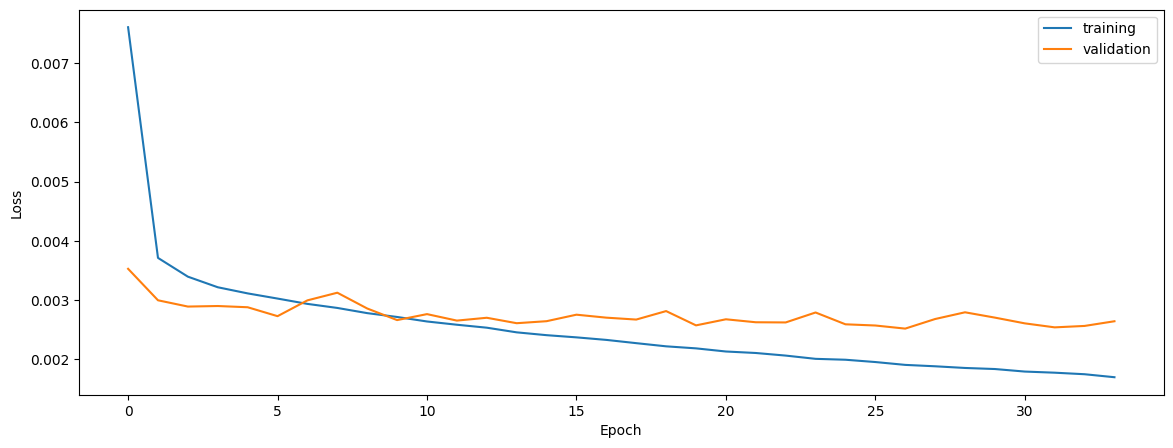

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8945352768980266
0.8421329091350649
0.8301911603784017


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8934195959792612
0.8588820640626796
0.8373732008911979


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8929814623966886
0.8572838581598292
0.8333544734696693


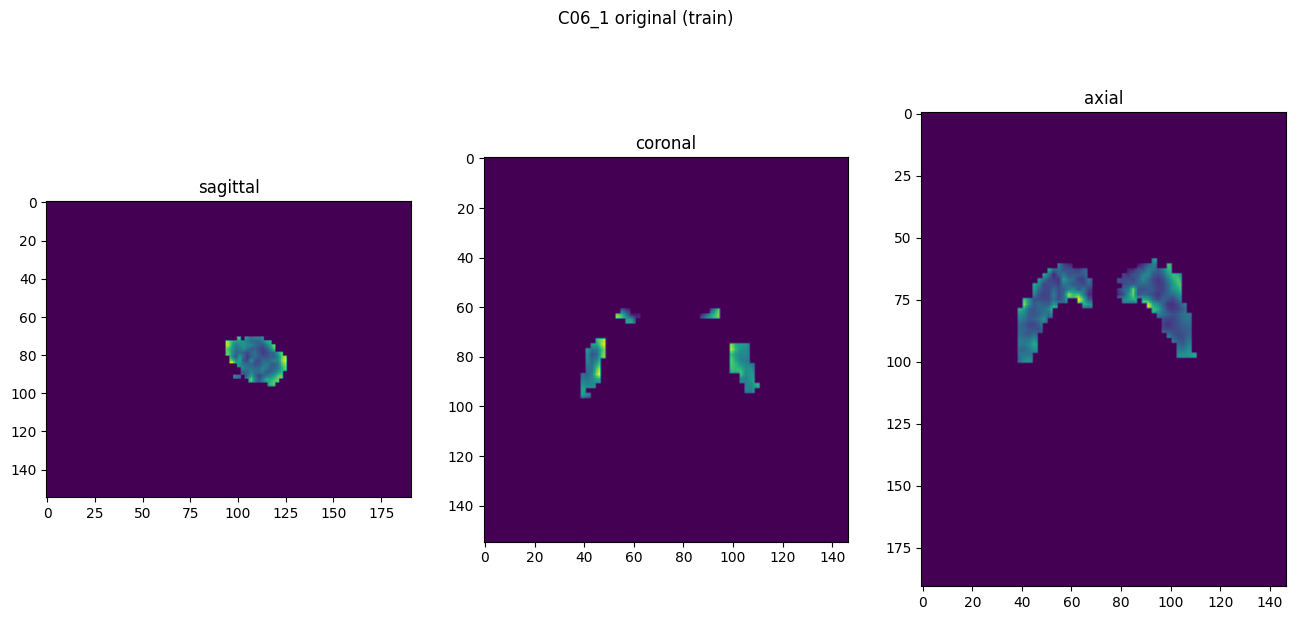

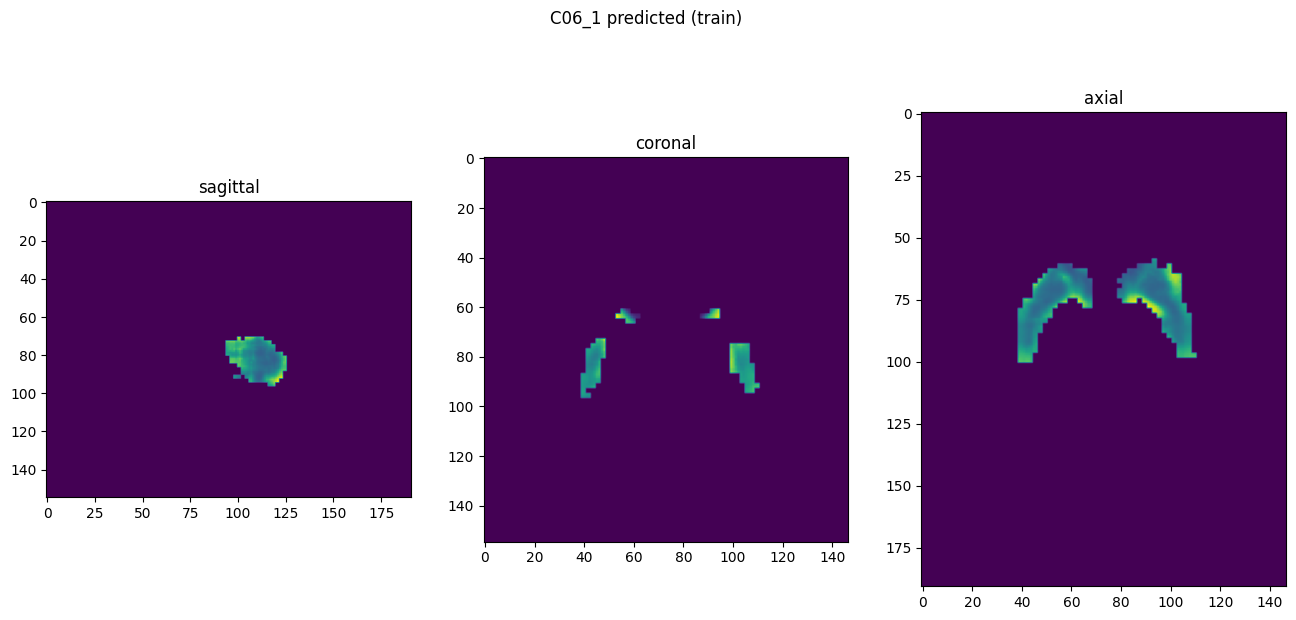

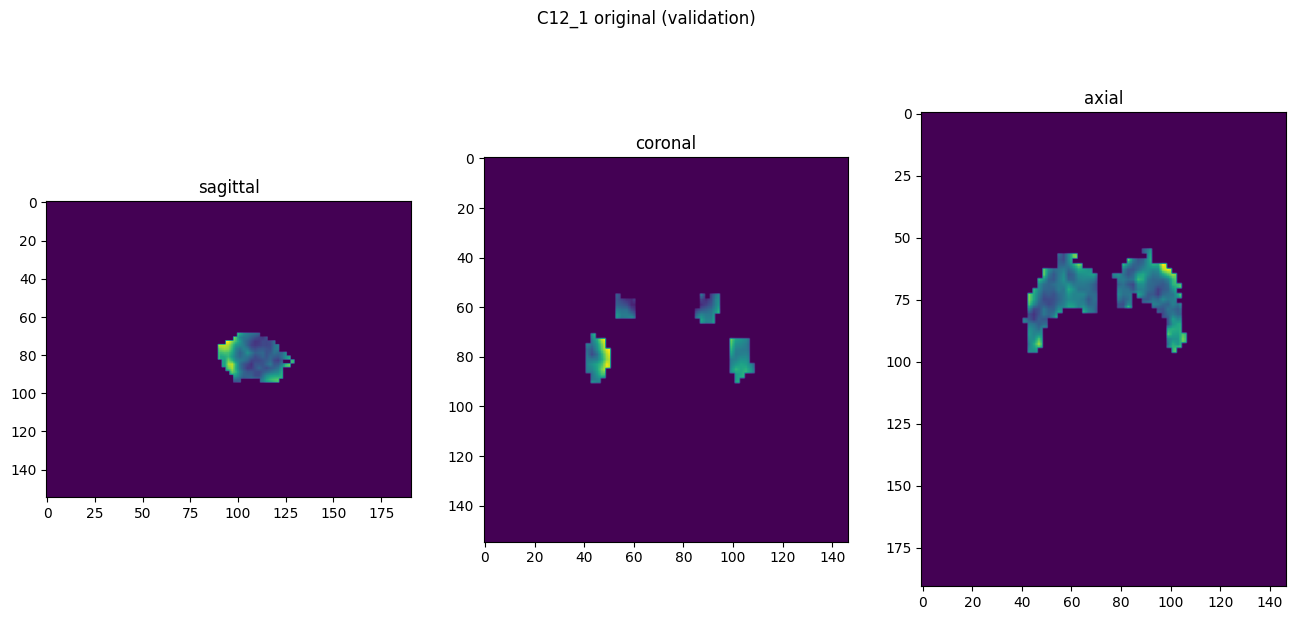

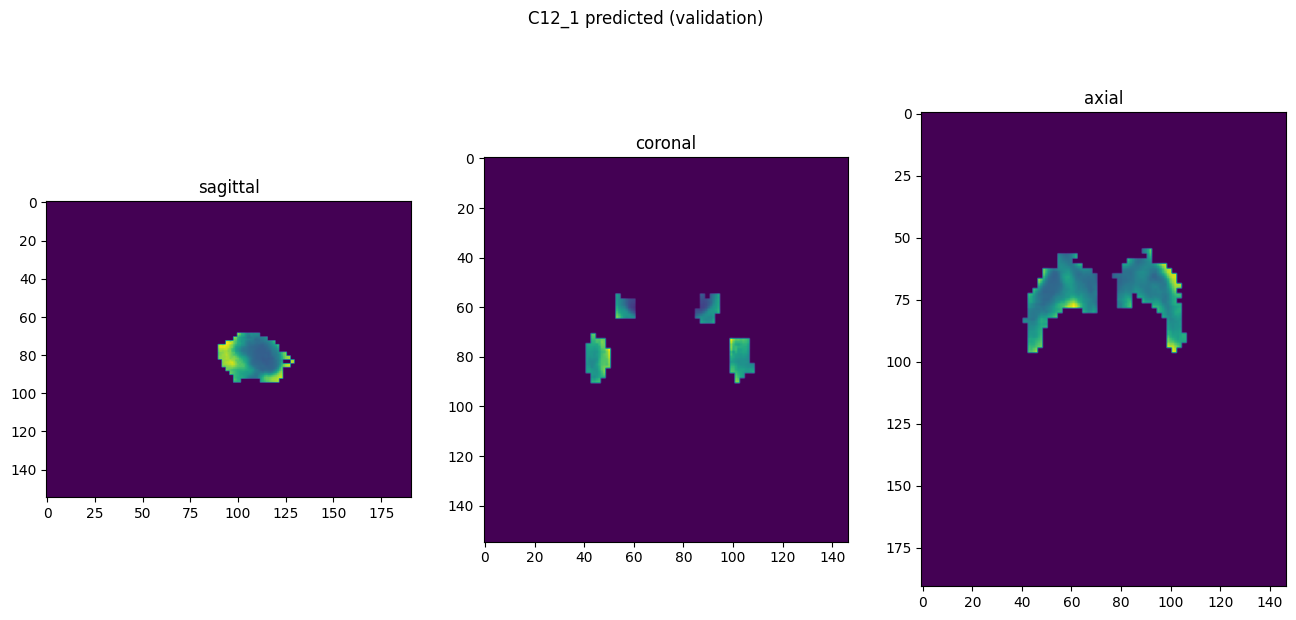

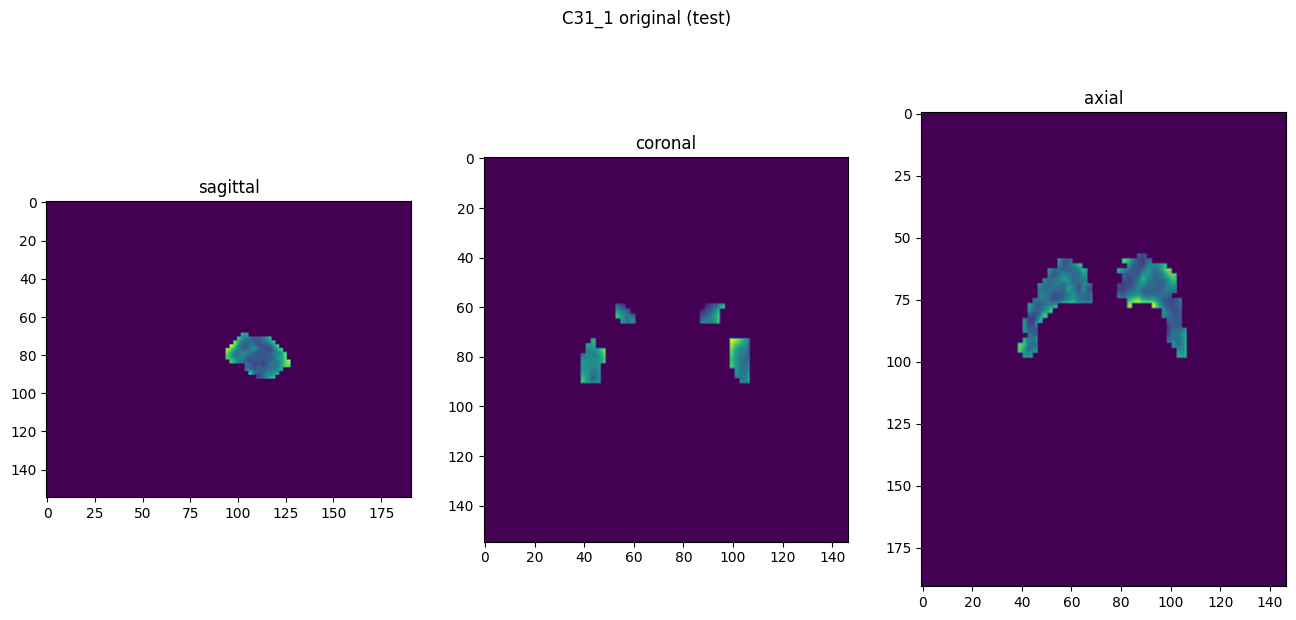

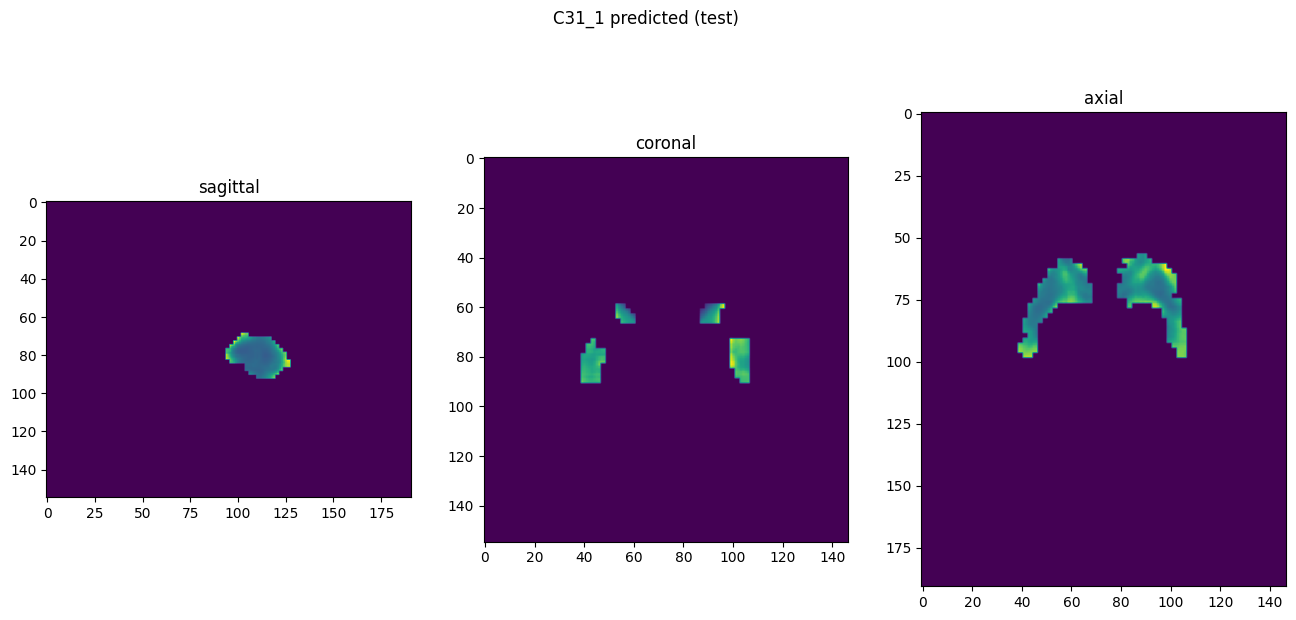

In [10]:
showResults(model, gen, threshold=None, background=False)